In [1]:
# !pip install opendatasets
# import opendatasets as od
# od.download('https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification')

In [2]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
from skimage.transform import resize
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_df = pd.read_csv('/kaggle/input/quran-recitations-for-audio-classification/files_paths.csv')
print(data_df['Class'].unique())
print(len(data_df['Class'].unique()))
data_df

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
12


,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan
...,...,...
6682,./Dataset/Abdullah_Albuaijan/Abdullah_148.wav,Abdullah_Albuaijan
6683,./Dataset/Abdullah_Albuaijan/Abdullah_014.wav,Abdullah_Albuaijan
6684,./Dataset/Abdullah_Albuaijan/Abdullah_028.wav,Abdullah_Albuaijan
6685,./Dataset/Abdullah_Albuaijan/Abdullah_202.wav,Abdullah_Albuaijan


In [4]:
data_df['FilePath'] = '/kaggle/input/quran-recitations-for-audio-classification/Dataset' + data_df['FilePath'].str[1:]
data_df.head()

,FilePath,Class
0,/kaggle/input/quran-recitations-for-audio-clas...,Mohammed_Aluhaidan
1,/kaggle/input/quran-recitations-for-audio-clas...,Mohammed_Aluhaidan
2,/kaggle/input/quran-recitations-for-audio-clas...,Mohammed_Aluhaidan
3,/kaggle/input/quran-recitations-for-audio-clas...,Mohammed_Aluhaidan
4,/kaggle/input/quran-recitations-for-audio-clas...,Mohammed_Aluhaidan


In [5]:
data_df['FilePath'].iloc[2]

'/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

data shape : (6687, 2)
class distribution : Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


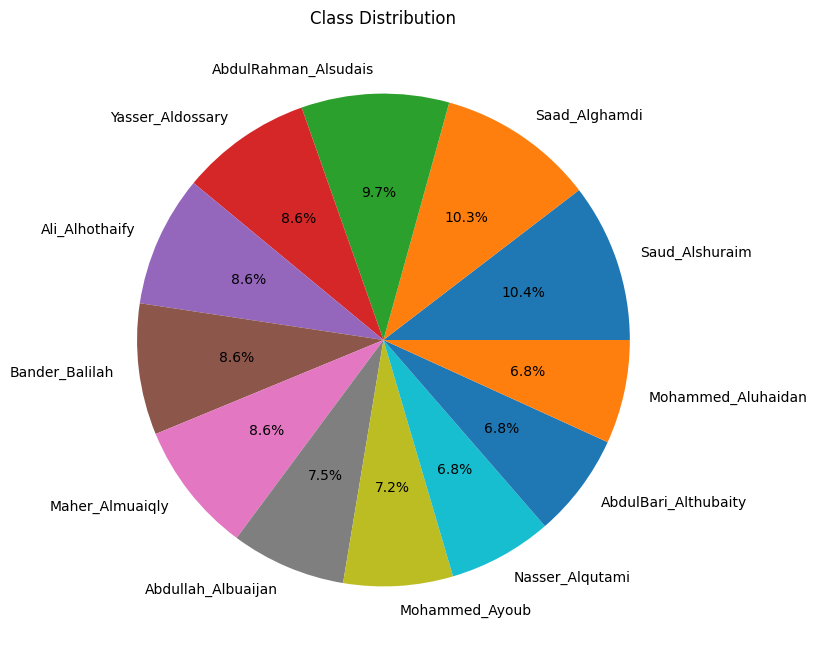

In [6]:
print('data shape :',data_df.shape)
print('class distribution :',data_df['Class'].value_counts())

plt.figure(figsize=(8,8))
plt.pie(data_df['Class'].value_counts(),labels=data_df['Class'].value_counts().index,autopct='%1.1f%%')

plt.title('Class Distribution')
plt.show()

In [7]:
label_encoder = LabelEncoder()
data_df['Class'] = label_encoder.fit_transform(data_df['Class'])

train = data_df.sample(frac=0.7,random_state=7)
test = data_df.drop(train.index)
val = test.sample(frac=0.5,random_state=7)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(4681, 2)
(1003, 2)
(1003, 2)


In [8]:
data_df['Class']

0       6
1       6
2       6
3       6
4       6
       ..
6682    2
6683    2
6684    2
6685    2
6686    2
Name: Class, Length: 6687, dtype: int64

In [9]:
class CustomAudioDataset(Dataset):
  def __init__(self,dataframe):
    self.dataframe = dataframe
    self.labels = torch.Tensor(list(dataframe['Class'])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = self.audios[idx].unsqueeze(0).to(device)
    return audio , label

  def get_spectogram(self,file_path):
    sr = 22050
    duration = 5

    img_height = 128
    img_width = 256

    signal , sr = librosa.load(file_path, sr = sr , duration= duration)

    spec = librosa.feature.melspectrogram(y = signal , sr = sr , n_fft=2024 , hop_length= 512 , n_mels=128)

    spec_db = librosa.power_to_db(spec,ref=np.max)

    spec_resized = librosa.util.fix_length(spec_db,size=(duration*sr)//512+1)
    spec_resized = resize(spec_resized,(img_height,img_width),anti_aliasing=True)

    return spec_resized

In [10]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [11]:
LR = 1e-4
BATCH_SIZE = 16
EPOCH = 25

In [12]:
train_loarder = DataLoader(train_dataset,batch_size = BATCH_SIZE , shuffle = True)
val_loarder = DataLoader(val_dataset,batch_size = BATCH_SIZE , shuffle = True)
test_loarder = DataLoader(test_dataset,batch_size = BATCH_SIZE , shuffle = True)


In [13]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(32,64,kernel_size=3,padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear((64*16*32),4096)
    self.linear2 = nn.Linear(4096,1024)
    self.linear3 = nn.Linear(1024,512)
    self.output = nn.Linear(512,len(data_df['Class'].unique()))

    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.conv2(x)
    x = self.pooling(x)
    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = x.view(x.size(0),-1)

    x = self.flatten(x)
    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)

    x = self.linear3(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

In [14]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:
from torchsummary import summary
summary(model,(1,128,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [16]:
criteration = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr = LR)

In [21]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
import time
start_time = time.time()
for epoch in range(EPOCH):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for input,labels in train_loarder:
    outputs = model(input)
    train_loss = criteration(outputs,labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for input,labels in val_loarder:
      outputs = model(input)
      val_loss = criteration(outputs,labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs,axis =1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

  print(f'''Epoch : {epoch+1}/{EPOCH} , Train Loss : {round(total_loss_train/1000,4)} , Train Acc : {round((total_acc_train/train_dataset.__len__())*100,4)}
        val Loss : {round(total_loss_val/1000,4)} , val Acc : {round((total_acc_val/val_dataset.__len__())*100,4)}
        ''')

print(round((time.time()-start_time)),4)

Epoch : 1/25 , Train Loss : 0.0732 , Train Acc : 92.3093
        val Loss : 0.0245 , val Acc : 88.7338
        
Epoch : 2/25 , Train Loss : 0.0639 , Train Acc : 92.9716
        val Loss : 0.018 , val Acc : 92.2233
        
Epoch : 3/25 , Train Loss : 0.0578 , Train Acc : 93.4629
        val Loss : 0.0358 , val Acc : 84.1476
        
Epoch : 4/25 , Train Loss : 0.0545 , Train Acc : 94.5311
        val Loss : 0.0157 , val Acc : 93.32
        
Epoch : 5/25 , Train Loss : 0.0429 , Train Acc : 96.0051
        val Loss : 0.0223 , val Acc : 89.8305
        
Epoch : 6/25 , Train Loss : 0.0472 , Train Acc : 95.4711
        val Loss : 0.0226 , val Acc : 92.4227
        
Epoch : 7/25 , Train Loss : 0.0766 , Train Acc : 93.0143
        val Loss : 0.0255 , val Acc : 92.2233
        
Epoch : 8/25 , Train Loss : 0.0434 , Train Acc : 95.941
        val Loss : 0.0262 , val Acc : 90.8275
        
Epoch : 9/25 , Train Loss : 0.0345 , Train Acc : 96.5178
        val Loss : 0.0189 , val Acc : 92.5224
     

In [25]:
with torch.no_grad():
    total_loss_test = 0 
    total_acc_test = 0
    for input , labels in test_loarder:
        prediction = model(input)
        acc = (torch.argmax(prediction,axis=1)==labels).sum().item()

        total_acc_test += acc

print(f"total test accuracy : {round(total_acc_test/test_dataset.__len__()*100,4)}")

total test accuracy : 94.8156


In [28]:
total_loss_train_plot

[0.0732,
 0.0639,
 0.0578,
 0.0545,
 0.0429,
 0.0472,
 0.0766,
 0.0434,
 0.0345,
 0.0295,
 0.043,
 0.0687,
 0.0442,
 0.0307,
 0.0399,
 0.0288,
 0.0466,
 0.0423,
 0.049,
 0.0446,
 0.0337,
 0.0401,
 0.0361,
 0.0426,
 0.0205]

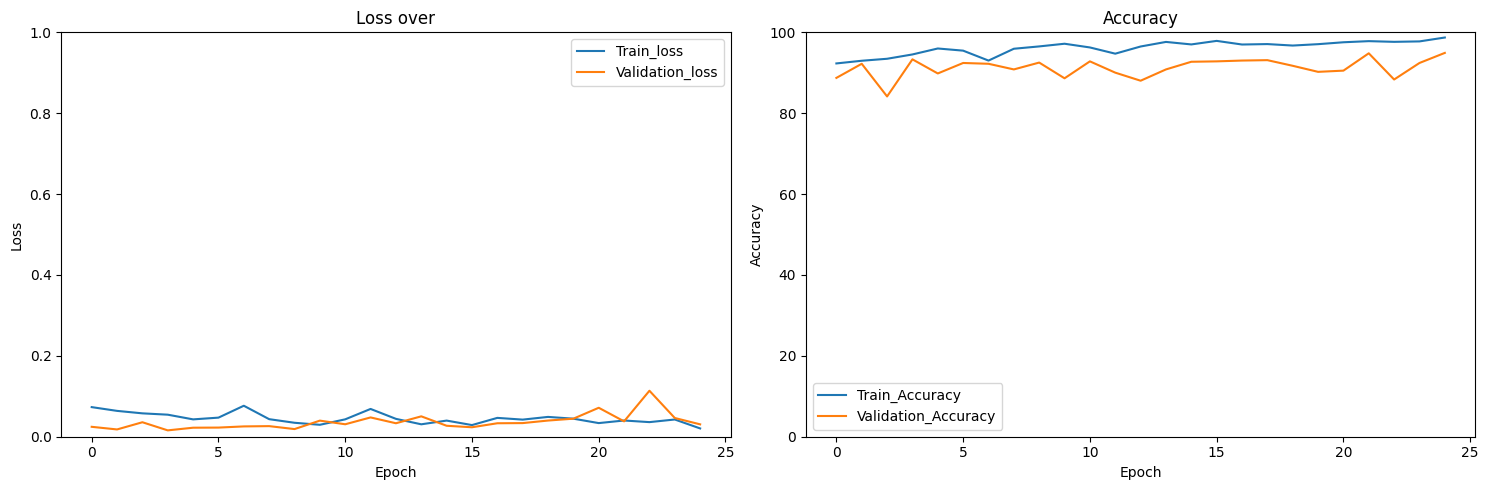

In [34]:
fig , axs = plt.subplots(nrows = 1,ncols=2 , figsize =(15, 5))

axs[0].plot(total_loss_train_plot , label = "Train_loss")
axs[0].plot(total_loss_validation_plot, label = "Validation_loss")
axs[0].set_title('Loss over')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_ylim(0,1)
axs[0].legend()

axs[1].plot(total_acc_train_plot , label = "Train_Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation_Accuracy")
axs[1].set_title('Accuracy')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim(0,100)
axs[1].legend()

plt.tight_layout()
plt.show()